# Código Base (Inspiração)

* link: https://goodboychan.github.io/python/tensorflow/mit/2021/02/14/music-generation.html
* link2: https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/
* link3: https://stackoverflow.com/questions/48118111/get-loss-values-for-each-training-instance-keras

# Bibliotecas

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # tf warning

# libraries
import numpy as np
import time
import regex as re
from IPython import display as ipythondisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
from music21 import converter
import collections
import random
from sklearn.model_selection import train_test_split

# fixa para executar na CPU (determinismo)
# devices = tf.config.list_physical_devices()
# tf.config.experimental.set_visible_devices(devices[0]) 

# semente aleatória
global_seed=301831
np.random.seed(global_seed)
random.seed(global_seed)
tf.random.set_seed(global_seed)

# Dados

In [2]:
def extract_song_snippet(text):
    pattern = '(^|\n\n)(.*?)\n\n'
    search_results = re.findall(pattern, text, overlapped=True, flags=re.DOTALL)
    songs = [song[1] for song in search_results]
    # print("Found {} songs in text".format(len(songs)))
    return songs

## Irish Dataset

In [ ]:
# cwd = os.getcwd()
# songs = []

# with open(os.path.join(cwd, 'data', 'irish', 'irish.abc'), 'r') as f:
#     text = f.read()
#     songs = extract_song_snippet(text)

# # # Exemplo de musica
# # example_song = songs[0]
# # print("\nExample song: ")
# # print(example_song)

## ABC Notation Dataset

In [3]:
def abc_filenames(datapath='abcnotation_midi-test', count=False):
    songs = [os.path.join(datapath, f) for f in os.listdir(datapath) if os.path.isfile(os.path.join(datapath, f))]
    if count==True:
        print('Found {} songs in directory'.format(len(songs)))
    return songs

datapath = "./data/abcnotation"
filenames = abc_filenames(datapath, count=False)
idx = np.random.choice(len(filenames), 500, replace=False)
filenames_selected = [filenames[i] for i in idx]
songs_text = ''
for filename in filenames_selected: 
    try:
            f = open(filename,'r', encoding='utf8')
            text = f.read()
            text = re.findall('X:.*', text, overlapped=True, flags=re.DOTALL)[0]
            songs_text += text
            f.close()
    except:
        print("Erro em:", filename)
        pass

songs = extract_song_snippet(songs_text)

# print(len(songs))
# print(len(filenames))

# example_song = songs[1]
# print("\nExample song: ")
# print(example_song)

Found 184900 songs in directory


# Tratando Base de Dados

In [4]:
def clean_abc(abc_song, show_rslt=False):
    # original .abc
    text = abc_song
    new_text = text

    # # remove index field
    # new_text = re.sub('(X:).*\n', '', new_text)

    # remove title field
    new_text = re.sub('(T:).*\n', '', new_text)

    # remove composer field
    new_text = re.sub('(C:).*\n', '', new_text)

    # remove source field
    new_text = re.sub('(S:).*\n', '', new_text)

    # remove geographical origin field
    new_text = re.sub('(O:).*\n', '', new_text)

    # remove textual notes field
    new_text = re.sub('(N:).*\n', '', new_text)

    # remove identity of transcriber/source of transcription field
    new_text = re.sub('(Z:).*\n', '', new_text)

    # remove lyrics
    new_text = re.sub('([wW]:).*\n','',new_text)
    new_text = re.sub('[wW]:','',new_text)


    # remove comments
    new_text = re.sub('(%).*\n','',new_text)

    # remove other fields
    new_text = re.sub('(R:).*\n','',new_text)
    new_text = re.sub('(I:).*\n','',new_text)
    new_text = re.sub('(B:).*\n','',new_text)

    if show_rslt==True:
        # print results
        print('original: '+str(len(text))+' characters'+'\n' + text)
        print()
        print('after modification: '+str(len(new_text))+' characters'+'\n' + new_text)

    return new_text

# example_song2 = clean_abc(songs[3], show_rslt=True)
# print(example_song2)

In [5]:
def extract_vocab(text):
    vocab = sorted(set(text))
    return {u:i for i, u in enumerate(vocab)}

for i in range(len(songs)):
    songs[i] = clean_abc(songs[i])

songs_joined = "\n\n".join(songs) 

# caracteres únicos disponíveis
vocab = extract_vocab(songs_joined)

print('Total Characters:', len(songs_joined))
print('Total Vocab:', len(vocab))

songs_train, songs_test = train_test_split(songs, train_size = 0.80)
songs_train_joined = "\n\n".join(songs_train)
songs_test_joined = "\n\n".join(songs_test)

Total Characters: 194944
Total Vocab: 101


In [6]:
# Create a mapping from character to unique index
def char2idx(string, vocab=None):
    if vocab==None:
        vocab = extract_vocab(string)
    vectorized_list = np.array([vocab[s] for s in string])
    return vectorized_list

# Create a mapping from indices to characters
def idx2char(idx, vocab):
    keys = list(vocab.keys())
    string = ''
    if isinstance(idx, collections.Iterable):
        for i in idx:
            string += keys[i]
    else:
        string += keys[idx]
    return string

# Preparando Dados para Treino (Ajuste) do Modelo

In [7]:
def prepare_train_data(vectorized_string, seq_length, method, batch_size=None, vocab=None):

  # Todas as Combinações + One Hot Encoding (Dummies)
  if method == 'full':
    x_train = []
    y_train = []

    n = len(vectorized_string)

    for i in range(0, n-seq_length, 1):
      seq_in = vectorized_string[i:i + seq_length]
      seq_out = vectorized_string[i + seq_length]
      x_train.append(seq_in)
      y_train.append(seq_out)

    n_patterns = len(x_train)

    x_train = np.reshape(x_train, (n_patterns, seq_length, 1))
    # normalize
    x_train = x_train / float(len(vocab))
    # one hot encode the output variable
    y_train = tf.keras.utils.to_categorical(y_train)


  # Lotes com tamanho específico + Word Embedding
  if method == 'batch':
    n = len(vectorized_string) - 1
    idx = np.random.choice(n-seq_length, batch_size)
    seq_in = [vectorized_string[i:i+seq_length] for i in idx]
    seq_out = [vectorized_string[i+1: i+1+seq_length] for i in idx]

    x_train = np.reshape(seq_in, [batch_size, seq_length])
    y_train = np.reshape(seq_out, [batch_size, seq_length])

  return x_train, y_train

# RNN LSTM Model

In [8]:
def build_model_wordEmbed(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    tf.keras.layers.LSTM(
    units=rnn_units, 
    activation='tanh',
    recurrent_activation='sigmoid',
    recurrent_initializer='glorot_uniform',
    use_bias=True,
    bias_initializer='zeros',
    return_sequences=True, 
    stateful=True
    ),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    tf.keras.layers.Dense(units=vocab_size)
  ])

  return model


def build_model_oneHotEnc(rnn_units, x_train, y_train):
  model = tf.keras.Sequential([
    # Layer 1: LSTM with `rnn_units` number of units. 
    tf.keras.layers.LSTM(
    units=rnn_units,
    input_shape=(x_train.shape[1], x_train.shape[2]), 
    activation='tanh',
    recurrent_activation='sigmoid',
    recurrent_initializer='glorot_uniform',
    use_bias=True,
    bias_initializer='zeros',
    return_sequences=False, 
    stateful=False,
    ),

    # Layer 2: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    tf.keras.layers.Dense(units=y_train.shape[1], activation='softmax')
  ])

  return model


In [9]:
def compute_loss_wordEmbed(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

def train_step_wordEmbed(x, y): 
  with tf.GradientTape() as tape:
    y_hat = model(x)
    loss = compute_loss_wordEmbed(y, y_hat)

  grads = tape.gradient(loss, model.trainable_variables)  
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss
  

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()
  
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))


In [10]:
# parameters
epochs = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 50  # Experiment between 50 and 500
learning_rate = 1e-3  # Experiment between 1e-5 and 1e-1 
vocab_size = len(vocab)
embedding_dim = 256 # Experiment between 8 and 1024
lstm_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

# train | test
vec_songs_train = char2idx(songs_train_joined, vocab)
vec_songs_test = char2idx(songs_test_joined, vocab)

## Batch + Word Embedding

In [14]:
model = build_model_wordEmbed(vocab_size, embedding_dim, lstm_units, batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate)

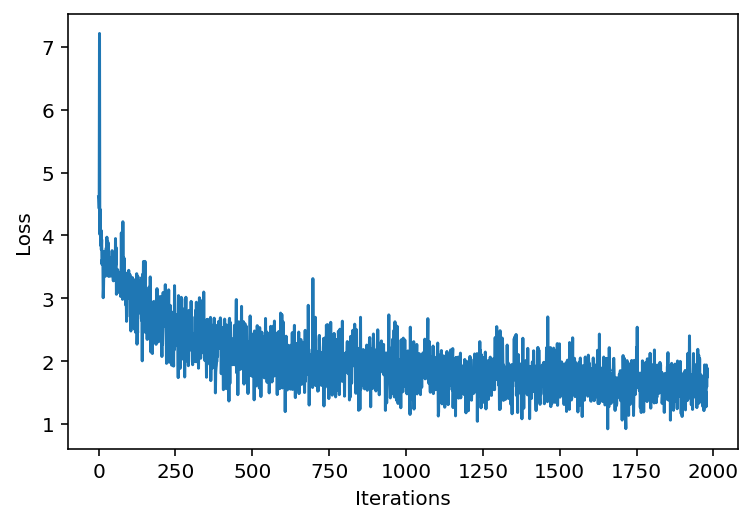

100%|██████████| 2000/2000 [01:41<00:00, 19.64it/s]


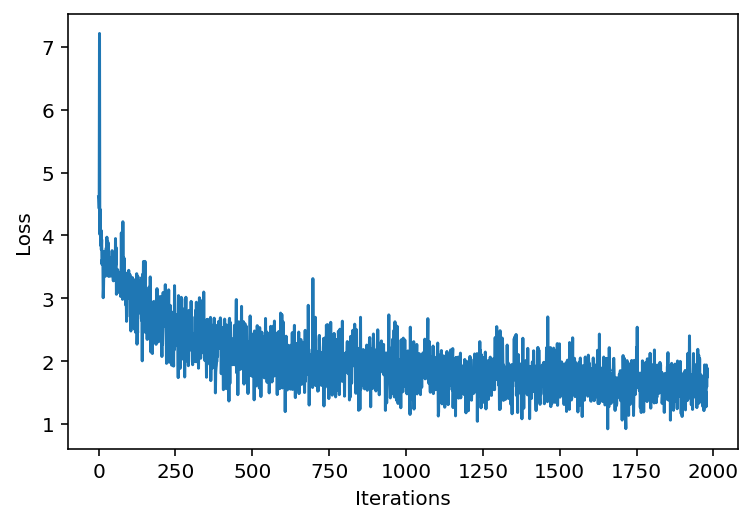

In [15]:
###################
# Begin training! #
###################

history = []
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(epochs)):

    # Grab a batch and propagate it through the network
    x_train, y_train = prepare_train_data(vectorized_string=vec_songs_train, seq_length=seq_length, method='batch', batch_size=batch_size)
    train_loss = train_step_wordEmbed(x_train, y_train)
    train_loss = train_loss.numpy().mean()

    # Update the progress bar
    history.append(train_loss)
    plotter.plot(history)

    # Update the model with the changed weights!
    if iter % 100 == 0:     
        model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)


In [16]:
x_test, y_test = prepare_train_data(vectorized_string=vec_songs_test, seq_length=seq_length, method='batch', batch_size=batch_size)
loss = []

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for i in tqdm(range(epochs)):
    y_hat = model(x_test)
    test_loss = compute_loss_wordEmbed(y_test, y_hat)
    test_loss = test_loss.numpy().mean()
    loss.append(test_loss)
test_loss = np.mean(loss)

100%|██████████| 2000/2000 [00:33<00:00, 59.04it/s]


In [17]:
print('train categorical cross-entropy loss =', train_loss)
print('train perplexity (2**) =', 2**(train_loss))
print('train perplexity (exp) =', tf.exp(train_loss).numpy())
print()
print('test categorical cross-entropy loss =', test_loss)
print('test perplexity (2**) =', 2**(test_loss))
print('test perplexity (exp) =', tf.exp(test_loss).numpy())

train categorical cross-entropy loss = 1.6134812
train perplexity (2**) = 3.05989291329999
train perplexity (exp) = 5.020257

test categorical cross-entropy loss = 1.4766865
test perplexity (2**) = 2.7830879052765347
test perplexity (exp) = 4.3784137


In [18]:
def generate_text_wordEmbed(model, start_string, vocab, generation_length):
  input_eval = [char2idx(s, vocab) for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  text_generated = []

  model.reset_states()
  
  for i in range(generation_length):
    predictions = model(input_eval)
    predictions = tf.squeeze(predictions, 0)
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
    input_eval = tf.expand_dims([predicted_id], 0)
    text_generated.append(idx2char(predicted_id, vocab))
    
  text = (start_string + ''.join(text_generated))
    
  return text

In [19]:
model = build_model_wordEmbed(vocab_size, embedding_dim, lstm_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

n_songs = 5
new_songs = []

tqdm._instances.clear()
with tqdm(total=n_songs) as pbar:
    while len(new_songs) < n_songs:
        n0 = len(new_songs)
        generated_text = generate_text_wordEmbed(model, start_string='X:', vocab=vocab, generation_length=1000)
        generated_songs = extract_song_snippet(generated_text)
        for song in generated_songs:
            new_songs.append(song)
        if len(new_songs) > n0:
            pbar.update(len(new_songs)-n0)
    
new_songs = new_songs[0:n_songs]

6it [00:34,  5.67s/it]                       


In [20]:
for song in new_songs:
    print(song)
    print()

X:1
Q:1/4=10
|:D2A2B2A2|G2G2F2|
G2|!G2 F2 FD|EEG2B2|\
A2E2E2 F4 A2 G2|d6 g2 f2 B3"A"A2 G4 | "F"G2 E2 "C7"F2G2 | "F7"G2F2 G2>G"G4 | "G7"B3/B/G/G/2 G3/2v2
M: A7"DD G>G"E>E | "G"D3- | G,2D2 | "Em"B<A F2 | 
"C7"e2b>a | "Eb/C"g>b | 
[V:4] C,>^ E,2D2z2 | 
[V:10] G,2z2] D2 F2||
d2 d3 c|B6 B2|F4 | 
[V:4] D,4E,2C2- [|] 
[V:2]  | 
[V:4] E,4D,2 | 
[V:1] f2d2A2- | 
[V:3] c4z2 | 
[V:4] A,4E,2D,,2G,,2C,2 | 
[V:10] C,2z2 | 
[V:1] c6c4 | 
[V:4] [F,2D,2(C2F,2D,2 | 
[V:1] z4G3 | 
[V:2] c2dG | 
[V:3] E,E,CC3- | 
[V:1] d2c2cBA2 | 
[V:2] c6z2 | 
[V:3] z8 ||  
[V:3] g3fee | 
[V:2] [c2G3][!wdc][B2A2-[_Ad][G2D2][FAF]|_[A2F2][A=c4A2][FE|[A2F2][FEG2|[G2B2][A,2]G[C2-[AF][2F4]|[D6F2|G6 F2F|FE F2 FG E3|Acde dcB|Bc d eA|B2 d c2 c|e2 g|g2f2 c2d2|dfee d2 dd|Bfed cBGE|D>GAB ABdB|AGA2 BAB GB dBA:|
B2dB efgf|e3d BAAB|
[1 D3] :|
M: 2/4
L: 1/8
K: Fmaj
e2ec | efefe2 | e2a2=a2e3 | d2A2d2 :|

X:1
M:4/2
L:1/8
K:A
f2 d B d|e3d d3 :|
GAA B3 c|B3 4| 
c>e f2 g> | f>D B>A |
"E"GA cB | "G"AGDD | "C7"AG ^F :| "G"GB cB dB | "F" G4
g4

## Full + One Hot Encoding

In [ ]:
# x_train, y_train = prepare_train_data(vectorized_string=test_song, seq_length=seq_length, method='full', vocab=vocab)
# x_train = x_train[0:200]
# y_train = y_train[0:200]
# model = build_model_oneHotEnc(lstm_units, x_train, y_train)
# optimizer = tf.keras.optimizers.Adam(learning_rate)
# model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [ ]:
# ###################
# # Begin training! #
# ###################

# history = []
# plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
# if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# for iter in tqdm(range(10)):
#     train_losses = LossHistory()
#     model.fit(x_train, y_train, epochs=1, batch_size=batch_size, callbacks=train_losses)
#     history.append(round(train_losses.losses[-1],4))
#     plotter.plot(history)

#     # Update the model with the changed weights!
#     if iter % 100 == 0:     
#         model.save_weights(checkpoint_prefix)

# # Save the trained model and the weights
# model.save_weights(checkpoint_prefix)

In [ ]:
# import sys

# seq_length = 100
# dataX = []
# dataY = []

# for i in range(0, n_chars - seq_length, 1):
#   seq_in = songs_joined[i:i + seq_length]
#   seq_out = songs_joined[i + seq_length]
#   dataX.append(char2idx(seq_in, vocab))
#   dataY.append(char2idx(seq_out, vocab))

# n_patterns = len(dataX)
# print('Total Patterns:', n_patterns)

# # pick a random seed
# start = np.random.randint(0, len(dataX)-1)
# pattern = list(dataX[start])
# print("Seed (start string):")
# print("\"", ''.join([idx2char(value, vocab) for value in pattern]), "\"")
# # generate characters
# for i in range(50):
# 	x = np.reshape(pattern, (1, len(pattern), 1))
# 	x = x / float(n_vocab)
# 	prediction = model.predict(x, verbose=0)
# 	index = np.argmax(prediction)
# 	result = idx2char(index, vocab)
# 	seq_in = [idx2char(value, vocab) for value in pattern]
# 	sys.stdout.write(result)
# 	pattern.append(index)
# 	pattern = pattern[1:len(pattern)]
# print("\nDone.")